In [1]:
import sys

sys.path.append("./../../src")

from Dataset import SpeechCommandsDataset
from torch.utils.data import DataLoader
from Transformer import SpeechCommandTransformer, train_transformer, calculate_class_weights
import torch
import torch.nn as nn
from torch.optim import AdamW

In [2]:
torch.cuda.empty_cache()

In [3]:
train_dataset = SpeechCommandsDataset("../../data/train", mode="modified")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=6)

test_dataset = SpeechCommandsDataset("../../data/test", mode="modified")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpeechCommandTransformer(num_classes=len(train_dataset.class_to_idx), device=device, stride=2, embed_dim=64, pos_embedding=True).to(device)

class_weights = calculate_class_weights(train_dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=0.00005, weight_decay=0.001)

train_transformer(train_loader, test_loader, model=model, num_epochs=10, device=device, criterion=criterion, optimizer=optimizer)

Epoch [1/10], Train Loss: 2.2429, Train Accuracy: 22.52, Test Accuracy: 19.87%


Epoch [2/10], Train Loss: 1.9037, Train Accuracy: 21.81, Test Accuracy: 23.34%


Epoch [3/10], Train Loss: 1.6519, Train Accuracy: 24.53, Test Accuracy: 27.10%
Early stopping at epoch 3
Best Test Accuracy: 0.00%, Best Train Accuracy: 0.00%


In [3]:
train_dataset = SpeechCommandsDataset("../../data/train", mode="modified")
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=6)

test_dataset = SpeechCommandsDataset("../../data/test", mode="modified")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SpeechCommandTransformer(num_classes=len(train_dataset.class_to_idx), device=device, stride=2, embed_dim=256, pos_embedding=True).to(device)

class_weights = calculate_class_weights(train_dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = AdamW(model.parameters(), lr=0.00005, weight_decay=0.001)

train_transformer(train_loader, test_loader, model=model, num_epochs=10, device=device, criterion=criterion, optimizer=optimizer)

Epoch [1/10], Train Loss: 2.2134, Train Accuracy: 16.81, Test Accuracy: 20.68%


Epoch [2/10], Train Loss: 1.5744, Train Accuracy: 25.20, Test Accuracy: 37.67%


Epoch [3/10], Train Loss: 1.1328, Train Accuracy: 37.57, Test Accuracy: 46.49%


Epoch [4/10], Train Loss: 0.9068, Train Accuracy: 46.74, Test Accuracy: 47.78%


Epoch [5/10], Train Loss: 0.7638, Train Accuracy: 54.01, Test Accuracy: 60.07%


Epoch [6/10], Train Loss: 0.6686, Train Accuracy: 59.34, Test Accuracy: 60.71%


Epoch [7/10], Train Loss: 0.6022, Train Accuracy: 63.19, Test Accuracy: 64.22%


Epoch [8/10], Train Loss: 0.5508, Train Accuracy: 65.52, Test Accuracy: 68.85%


Epoch [9/10], Train Loss: 0.5135, Train Accuracy: 67.53, Test Accuracy: 68.14%


Epoch [10/10], Train Loss: 0.4760, Train Accuracy: 69.88, Test Accuracy: 69.67%
Best Test Accuracy: 69.67%, Best Train Accuracy: 69.88%


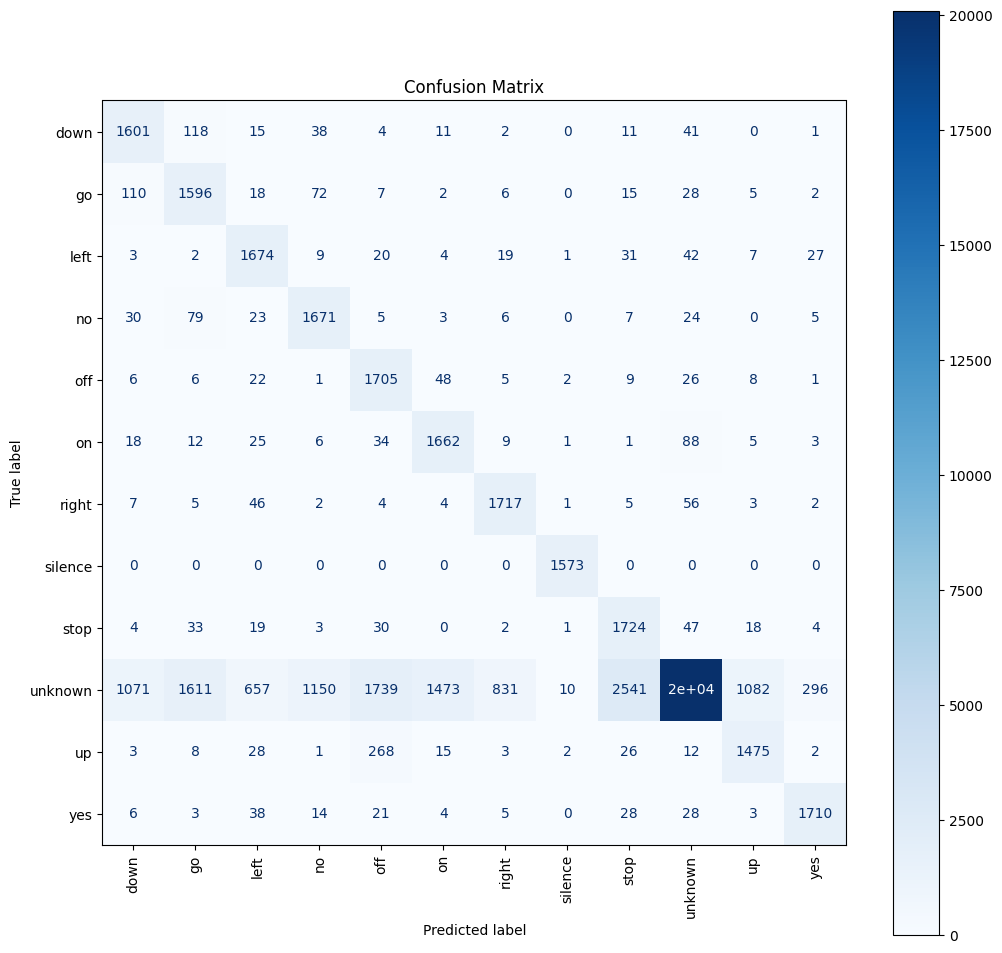

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
true_labels = []
pred_labels = []
with torch.no_grad():
    for waveforms, labels in train_loader:
        waveforms = waveforms.squeeze(1).to(device)
        labels = labels.to(device)

        outputs = model(waveforms)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)

label_names = list(train_dataset.class_to_idx.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(include_values=True, xticks_rotation="vertical", ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()